In [3]:
!pip install librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.io.wavfile import write
from scipy.signal import correlate


In [4]:
SYMBOLS_PER_BLOCK = 2047
N_DFT = 2 * (SYMBOLS_PER_BLOCK + 1)
CYCLIC_PREFIX = N_DFT // 4
BLOCK_LENGTH = N_DFT + CYCLIC_PREFIX

SAMPLING_RATE = 48000

CHIRP_FACTOR = 0.01
CHIRP_LENGTH = BLOCK_LENGTH
CHIRP_LOW = 20
CHIRP_HIGH = 20000

NUMBER_OF_BLOCKS = 200

In [5]:
bits_per_symbol = 2
num_qpsk_symbols = SYMBOLS_PER_BLOCK * NUMBER_OF_BLOCKS
num_bits = bits_per_symbol * num_qpsk_symbols
bits = np.random.randint(0, 2, num_bits)
print(len(bits))

818800


In [6]:
mapping = {
    (0, 0): 1 + 1j,
    (0, 1): -1 + 1j,
    (1, 0): 1 - 1j,
    (1, 1): -1 - 1j,
}
mapping = {k: v / np.sqrt(2) for k, v in mapping.items()}
inv_mapping = {v: k for k, v in mapping.items()}

def qpsk_modulate(bits):
    bits = bits.reshape((-1, 2))
    symbols = np.array([mapping[tuple(b)] for b in bits]) / np.sqrt(2)
    return symbols

qpsk_symbols = qpsk_modulate(bits)
print(len(qpsk_symbols))

409400


In [7]:
ofdm_blocks = []

for i in range(NUMBER_OF_BLOCKS):
    data = qpsk_symbols[i * SYMBOLS_PER_BLOCK: (i+1) * SYMBOLS_PER_BLOCK]
    freq = np.zeros(N_DFT, dtype=complex)
    freq[1:SYMBOLS_PER_BLOCK + 1] = data
    freq[-SYMBOLS_PER_BLOCK:] = np.conj(data[::-1])
    
    # 4. IFFT
    time = np.fft.ifft(freq)
    time = np.real(time)
    
    # 5. Add cyclic prefix
    cyclic_prefix = time[-CYCLIC_PREFIX:]
    block_with_cp = np.concatenate([cyclic_prefix, time])
    ofdm_blocks.append(block_with_cp)


In [8]:
def generate_chirp(length, fs, f0, f1):
    t = np.linspace(0, length / fs, length, endpoint=False)
    k = (f1 - f0) / (length / fs)
    return CHIRP_FACTOR * np.sin(2 * np.pi * (f0 * t + 0.5 * k * t**2))

start_chirp = generate_chirp(CHIRP_LENGTH, SAMPLING_RATE, CHIRP_LOW, CHIRP_HIGH)
end_chirp = generate_chirp(CHIRP_LENGTH, SAMPLING_RATE, CHIRP_HIGH, CHIRP_LOW)

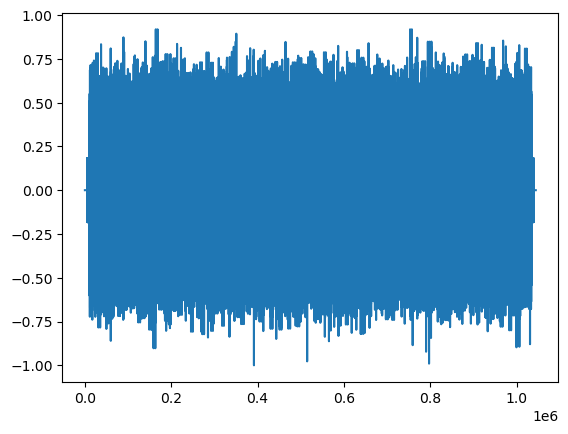

In [9]:
padding = np.zeros(BLOCK_LENGTH)

# New final signal with padding
signal = np.concatenate([
    padding,         # zero pad at the beginning
    start_chirp,     # start chirp
    *ofdm_blocks,    # OFDM blocks
    end_chirp,       # end chirp
    padding          # zero pad at the end
])
signal_normalized = signal / np.max(np.abs(signal))
plt.plot(signal_normalized)
plt.show()
write("output.wav", SAMPLING_RATE, signal_normalized.astype(np.float32))

/var/folders/nc/m09hvbqj5tg36pc2mtfzqhbc0000gp/T/ipykernel_48053/579410976.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  received_signal, sr = librosa.load(received_audio, sr=SAMPLING_RATE, mono=True)
/Users/benlou/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


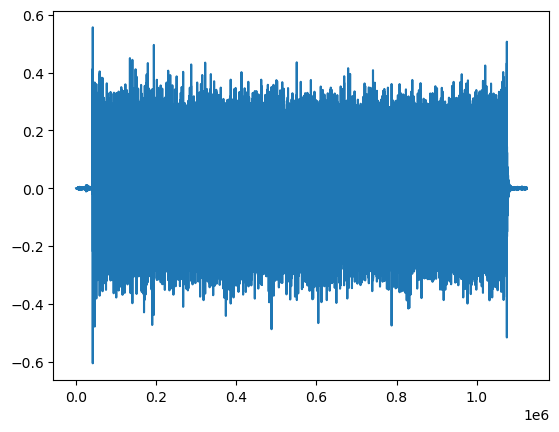

In [48]:
received_audio = "output.wav"
received_audio = "New Recording 15.m4a"
received_signal, sr = librosa.load(received_audio, sr=SAMPLING_RATE, mono=True)
plt.plot(received_signal)
plt.show()

In [53]:
corr_start = correlate(received_signal, start_chirp, mode='valid')
start_index = np.argmax(np.abs(corr_start))

corr_end = correlate(received_signal, end_chirp, mode='valid')
end_index = np.argmax(np.abs(corr_end))

print(start_index, end_index)
expected_length = CHIRP_LENGTH + BLOCK_LENGTH * NUMBER_OF_BLOCKS
print("Number of data samples:", (end_index - start_index))
print("Expected length:", expected_length)

41370 1070507
Number of data samples: 1029137
Expected length: 1029120


1029120


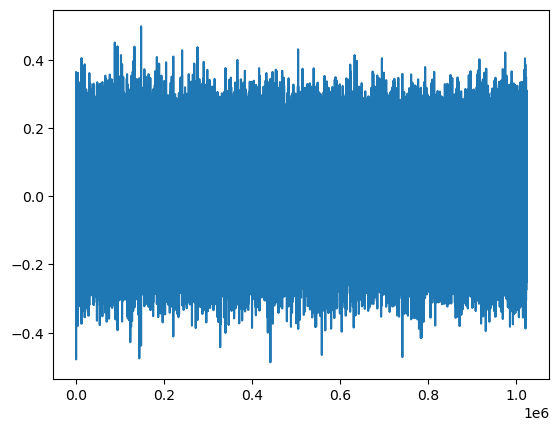

In [54]:
extracted_ofdm = received_signal[start_index:end_index]
sampling_ratio = expected_length / len(extracted_ofdm)
extracted_resampled = librosa.resample(extracted_ofdm, orig_sr=SAMPLING_RATE, target_sr=SAMPLING_RATE * sampling_ratio)
print(len(extracted_resampled))
extracted_resampled = extracted_resampled[CHIRP_LENGTH: CHIRP_LENGTH+expected_length]
plt.plot(extracted_resampled)
plt.show()

In [55]:
ofdm_blocks_time = extracted_resampled.reshape((NUMBER_OF_BLOCKS, BLOCK_LENGTH))

# Remove cyclic prefix and apply FFT
ofdm_blocks_freq = []

for block in ofdm_blocks_time:
    block_no_cp = block[CYCLIC_PREFIX:]           # Remove CP → now length = N_DFT
    block_fft = np.fft.fft(block_no_cp)           # FFT → returns N_DFT complex values
    ofdm_blocks_freq.append(block_fft)

ofdm_blocks_freq = np.array(ofdm_blocks_freq)

demodulated_symbols = ofdm_blocks_freq[:, 1:SYMBOLS_PER_BLOCK + 1]
qpsk_symbols = qpsk_symbols.reshape(demodulated_symbols.shape)

# True channel
channel_coefficients = demodulated_symbols / qpsk_symbols

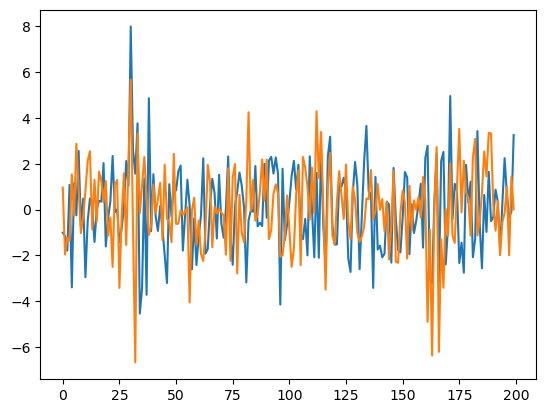

In [56]:
plt.plot(channel_coefficients[:,2].real)
plt.plot(channel_coefficients[:,2].imag)
plt.show()

In [57]:
# kernel = np.array([1/2,0,1/2])
# estimated_channel_coefficients = np.array([np.convolve(column, kernel, mode='same') for column in channel_coefficients.T]).T
# print(estimated_channel_coefficients[:9,20])
estimated_channel_coefficients = np.mean(channel_coefficients, axis=0)
estimated_symbols = demodulated_symbols / estimated_channel_coefficients
estimated_symbols = demodulated_symbols * np.conjugate(estimated_channel_coefficients)/(np.abs(estimated_channel_coefficients)**2 + 1/100)

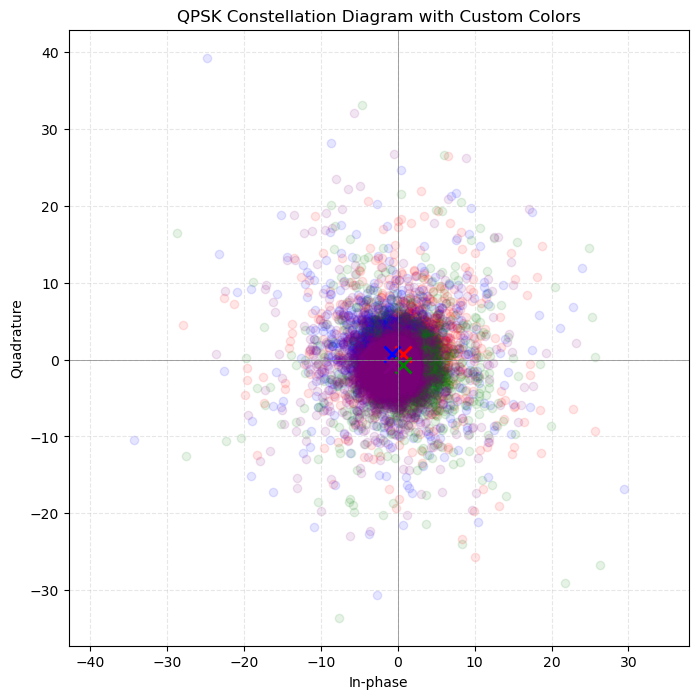

In [46]:
colors = ['red', 'blue', 'green', 'purple']

constellation_points = list(mapping.values())

tx = qpsk_symbols.flatten()
rx = estimated_symbols.flatten()
rx = rx / np.sqrt(np.mean(np.abs(rx)**2)) * np.sqrt(2)

# Assign each transmitted symbol a color index based on its closest ideal point
def find_closest_constellation(symbol, constellation):
    distances = [np.abs(symbol - c) for c in constellation]
    return np.argmin(distances)

# Get color labels based on transmitted symbols' closest constellation points
color_labels = np.array([find_closest_constellation(sym, constellation_points) for sym in tx])

# Plot received points colored by intended QPSK cluster
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.scatter(rx.real[color_labels == i], rx.imag[color_labels == i], color=colors[i], label=f'Cluster {i}', alpha=0.1)

# Plot ideal constellation points in matching color
for i, point in enumerate(constellation_points):
    plt.plot(point.real, point.imag, 'x', color=colors[i], markersize=12, mew=2, label=f'QPSK {i}')

# Formatting
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')
plt.title("QPSK Constellation Diagram with Custom Colors")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")
plt.show()


In [58]:
decoded_symbols = np.array([find_closest_constellation(sym, constellation_points) for sym in rx])
original_symbols = np.array([find_closest_constellation(sym, constellation_points) for sym in tx])
print("Correctness:", np.sum(decoded_symbols == original_symbols) / len(original_symbols))

decoded_bits = ""
for sym in decoded_symbols:
    if sym == 0: decoded_bits += "00"
    elif sym == 1: decoded_bits += "01"
    elif sym == 2: decoded_bits += "10"
    elif sym == 3: decoded_bits += "11"
    else: exit("symbol error")
decoded_bits = np.array([int(bit) for bit in decoded_bits])

print("Error rate:", np.sum(decoded_bits != bits) / len(bits))

Correctness: 0.5673424523693209
Error rate: 0.2719357596482658
